In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import sys

RAW = [
    "accelerometer", "gyroscope"
]

SIGNALS = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"
]

In [2]:
def show(x,y,z):
    plt.subplots_adjust(bottom=1, top=2)
    plt.subplot(311)
    plt.plot(x)
    plt.title('X')
    plt.show()
    plt.clf()
    plt.subplots_adjust(bottom=1, top=2)
    plt.subplot(312)
    plt.plot(y)
    plt.title('Y')
    plt.show()
    plt.clf()
    plt.subplots_adjust(bottom=1, top=2)
    plt.subplot(313)
    plt.plot(z)
    plt.title('Z')
    plt.show()

In [3]:
def _read_csv(signal):    
    return pd.read_csv(f'../data_allocation/{signal}.csv', delim_whitespace=True, header=None)

In [4]:
def _string_to_float(List): # [ "ax" / "ay" / "az" ]
    after = []
    for i in range(len(List)):
        after.append( float( List[i].split("\"")[1] ) )
    return after # [ ax / ay / az ]

def Transform_to_Digital_Data(raw_data): # [ UID / "ax" / "ay" / "az" / "timestamp" / "abs" / "accuracy" ]
    X = []; Y = []; Z = []
    samples = raw_data.shape[0]
    print('samples:', samples)
    for sample in range(samples):
        acc_data = _string_to_float( raw_data[sample][0].split(',')[1:4] ) # [ "ax" / "ay" / "az" ] => [ ax / ay / az ]
        X.append(acc_data[0])
        Y.append(acc_data[1])
        Z.append(acc_data[2])
    return X, Y, Z

In [22]:
data = []
for signal in RAW:
    data.append(_read_csv(signal).to_numpy()) # data[0]->acce, data[1]->gyro

acce_data = Transform_to_Digital_Data(data[0])
gyro_data = Transform_to_Digital_Data(data[1])

for i in range(3):
    for j in range(len(acce_data[i])):
        acce_data[i][j] = acce_data[i][j]/9.80665

samples: 491
samples: 516
[-0.08738835901021957, -0.10055647045373917, -0.10055647045373917, -0.08738835901021957, -0.09576806426048279, -0.09576806426048279, -0.09816227108240128, -0.09457096457481384, -0.09576806426048279, -0.10055647045373917]
[-0.008911132650825672, -0.010253906324151385, -0.010253906324151385, -0.008911132650825672, -0.009765624781192639, -0.009765624781192639, -0.010009765932545904, -0.009643554585389898, -0.009765624781192639, -0.010253906324151385]


In [23]:
# show(acce_data[0], acce_data[1], acce_data[2])

In [24]:
# show(gyro_data[0], gyro_data[1], gyro_data[2])

In [25]:
from scipy import interpolate

def Interpolate(data, new_samples, kind):
    old_samples = len(data[0])
    print('old_samples:', old_samples)
    print('new_samples:', new_samples)
    
    old_len=np.linspace(0,old_samples,old_samples)
    new_len=np.linspace(0,old_samples,new_samples)
    
    fx = interpolate.interp1d(old_len, data[0], kind=kind)
    fy = interpolate.interp1d(old_len, data[1], kind=kind)
    fz = interpolate.interp1d(old_len, data[2], kind=kind)
    
    newX = fx(new_len)
    newY = fy(new_len)
    newZ = fz(new_len)
    
#     show(data[0], data[1], data[2])
#     show(newX, newY, newZ)
    
    return newX, newY, newZ
        

In [26]:
interpolate_kind = ["nearest","zero","slinear","quadratic","cubic"]

if len(acce_data[0])>len(gyro_data[0]):
    gyro_data = Interpolate(gyro_data, len(acce_data[0]), interpolate_kind[4])
elif len(acce_data[0])<len(gyro_data[0]):
    acce_data = Interpolate(acce_data, len(gyro_data[0]), interpolate_kind[4])
else: print("Done.")

old_samples: 491
new_samples: 516


In [27]:
from scipy import signal

def MedianFilter(data):
    return signal.medfilt(data, 3)

def LowPassButterworthFilter(cutoff, freq, data):
    b,a = signal.butter(3, 2*cutoff/freq, btype='lowpass', analog=False, output='ba')
    return signal.filtfilt(b, a, data)

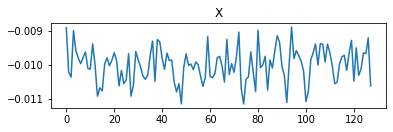

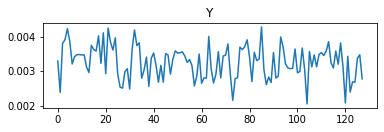

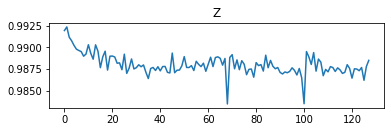

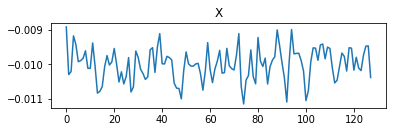

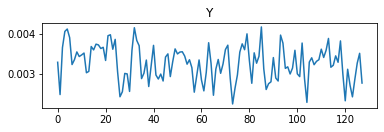

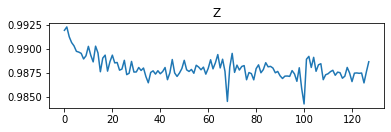

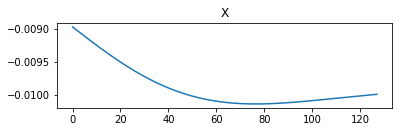

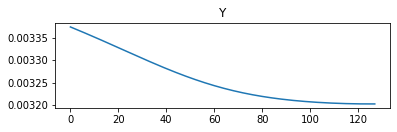

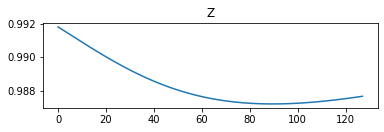

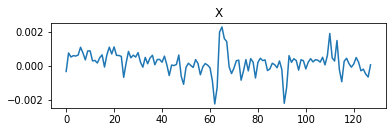

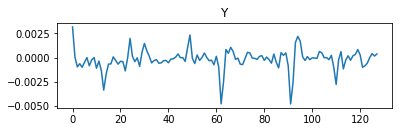

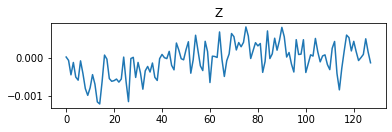

In [28]:
g = 0.3
cutoff = 20
freq = 50

show(acce_data[0][:128], acce_data[1][:128], acce_data[2][:128])

_median_acce = [MedianFilter(acce_data[0]), MedianFilter(acce_data[1]), MedianFilter(acce_data[2])]
_median_gyro = [MedianFilter(gyro_data[0]), MedianFilter(gyro_data[1]), MedianFilter(gyro_data[2])]
_LPBW_acce = [LowPassButterworthFilter(cutoff, freq, acce_data[0]),
              LowPassButterworthFilter(cutoff, freq, acce_data[1]),
              LowPassButterworthFilter(cutoff, freq, acce_data[2])]
_LPBW_gyro = [LowPassButterworthFilter(cutoff, freq, gyro_data[0]),
              LowPassButterworthFilter(cutoff, freq, gyro_data[1]),
              LowPassButterworthFilter(cutoff, freq, gyro_data[2])]
_LPBW_G = [LowPassButterworthFilter(g, freq, acce_data[0]),
           LowPassButterworthFilter(g, freq, acce_data[1]),
           LowPassButterworthFilter(g, freq, acce_data[2])]

# show(_LPBW_acce[0][:128], _LPBW_acce[1][:128], _LPBW_acce[2][:128])
# show(_LPBW_G[0][:128], _LPBW_G[1][:128], _LPBW_G[2][:128])
# show(_LPBW_gyro[0][:128], _LPBW_gyro[1][:128], _LPBW_gyro[2][:128])

In [29]:
# 'body_acc': The body acceleration signal obtained by subtracting the gravity from the total acceleration. 
# 'body_gyro': The angular velocity vector measured by the gyroscope for each window sample. The units are radians/second. 
# 'total_acc': The acceleration signal in standard gravity units 'g'.

body_acce_samples = [_LPBW_acce[0]-_LPBW_G[0], _LPBW_acce[1]-_LPBW_G[1], _LPBW_acce[2]-_LPBW_G[2]]
body_gyro_samples = _LPBW_gyro
total_acce_samples = _LPBW_acce

In [30]:
def _split(samples, data):
    after = []
    for index in range(samples-1):
        after.append( data[index*64:(index+2)*64] )
    after = np.transpose(after, (0,1))
    return after
    
def Shape(data):
    samples = int(len(data[0])/64)    
    return _split(samples,data[0]), _split(samples,data[1]), _split(samples, data[2])

In [31]:
body_acce = Shape(body_acce_samples)
body_gyro = Shape(body_gyro_samples)
total_acce = Shape(total_acce_samples)
# print(body_acce[0].shape[0])
# print(body_acce[0][0].shape)
# print(body_acce[0][0][0])

In [32]:
def WriteSignal(body_acce, body_gyro, total_acce, activity, samples):
#     Save data
    index = 0
    for signal in SIGNALS:
        index = index+1
        filename = f'../phonesData/{signal}.txt'
        with open(filename, 'w') as f:
        # w 建&寫 / w+ 建&寫&讀 / r 讀 / r+ 讀&寫 / a 續寫 / a+續寫&讀 / b 二進位模式
        
            if index<=3: target = body_acce[index-1]
            elif index<=6: target = body_gyro[index-4]
            elif index<=9: target = total_acce[index-7]
            
            np.savetxt(f, target, fmt="%.7e")
            # %.7e 科學記號到小數第7位 / %d 整數 / %.2f 浮點數到小數第2位 / %s 字串
    
#     Save target
    y = np.empty(shape=(samples,1))
    y.fill(activity)
    filename = f'../phonesData/y.txt'
    with open(filename, 'w') as f:
        np.savetxt(f, y, fmt="%d")

In [35]:
print("Please choose your activity:\n1) Walking\n2) Upstairs\n3) Downstairs\n4) Sitting\n5) Standing\n6) Laying")
    
WriteSignal(body_acce, body_gyro, total_acce, int(input()), body_acce[0].shape[0])

Please choose your activity:
1) Walking
2) Upstairs
3) Downstairs
4) Sitting
5) Standing
6) Laying
4


In [36]:
from scipy.fftpack import fft
def _FFT(data):
    return abs(fft(data))/128
def Time_to_Freq(data):
    new_data = []
    for i in range(len(data)):
        new_data.append( _FFT(data[i]) )
    return new_data

In [37]:
data = [body_acce, body_gyro, total_acce]
fft_data = Time_to_Freq(data)

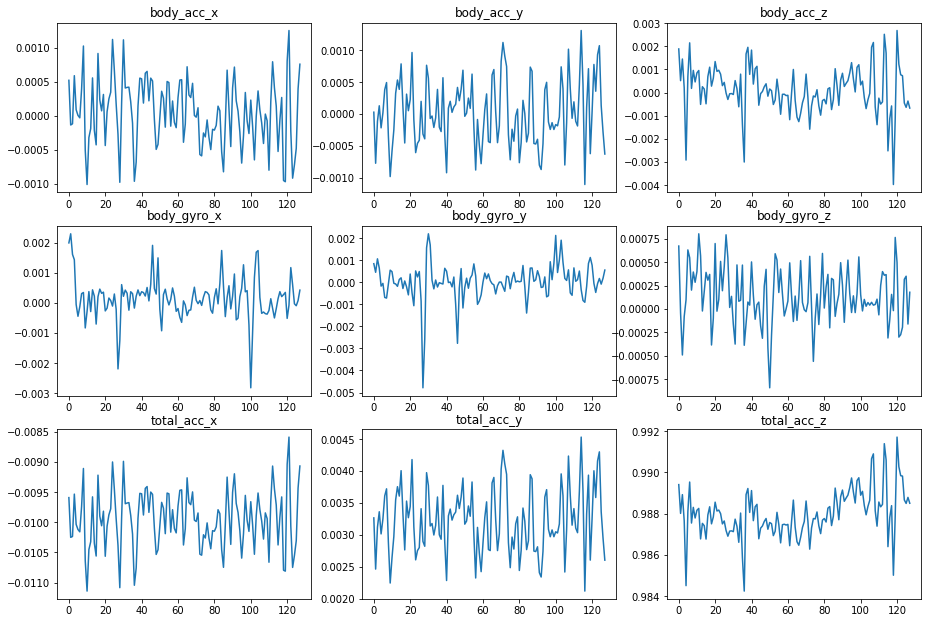

<Figure size 432x288 with 0 Axes>

In [38]:
plt.subplots_adjust(bottom=1, top=3, left=1, right=3)
for signal in range(9):
    plt.subplot(331+signal)
    plt.title(SIGNALS[signal])
    plt.plot(data[int(signal/3)][int(signal%3)][1]) 
plt.show()
plt.clf()

In [20]:
body_acc_x = pd.read_csv('../testData/body_acc_x_test.txt', delim_whitespace=True, header=None).to_numpy()
body_acc_y = pd.read_csv('../testData/body_acc_y_test.txt', delim_whitespace=True, header=None).to_numpy()
body_acc_z = pd.read_csv('../testData/body_acc_z_test.txt', delim_whitespace=True, header=None).to_numpy()
total_acc_x = pd.read_csv('../testData/total_acc_x_test.txt', delim_whitespace=True, header=None).to_numpy()
total_acc_y = pd.read_csv('../testData/total_acc_y_test.txt', delim_whitespace=True, header=None).to_numpy()
total_acc_z = pd.read_csv('../testData/total_acc_z_test.txt', delim_whitespace=True, header=None).to_numpy()
body_gyro_x = pd.read_csv('../testData/body_gyro_x_test.txt', delim_whitespace=True, header=None).to_numpy()
body_gyro_y = pd.read_csv('../testData/body_gyro_y_test.txt', delim_whitespace=True, header=None).to_numpy()
body_gyro_z = pd.read_csv('../testData/body_gyro_z_test.txt', delim_whitespace=True, header=None).to_numpy()

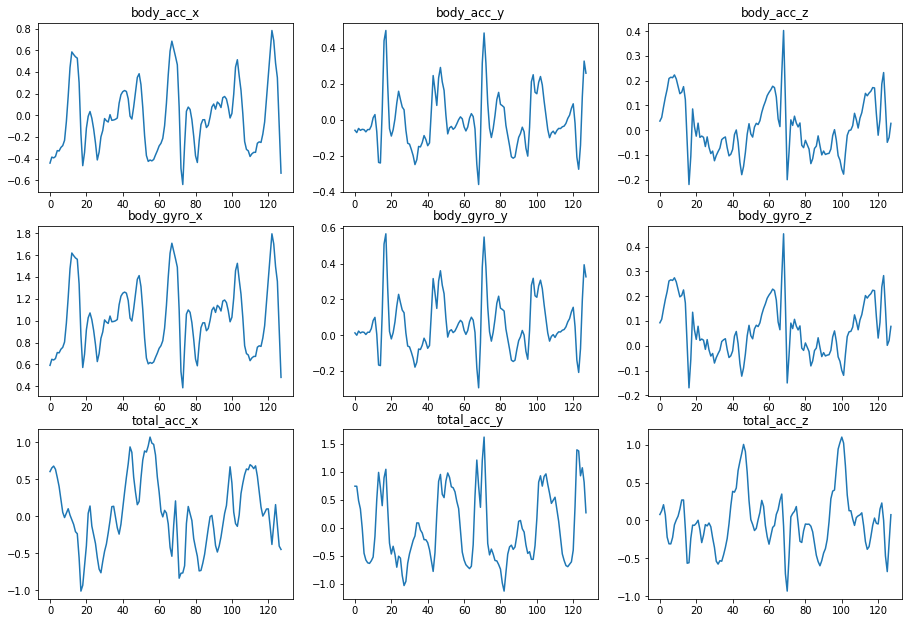

<Figure size 432x288 with 0 Axes>

In [39]:
index = random.randint(0,2946)
list = [body_acc_x[index], body_acc_y[index], body_acc_z[index], 
        total_acc_x[index], total_acc_y[index], total_acc_z[index],
        body_gyro_x[index], body_gyro_y[index], body_gyro_z[index]]
###### x朝下 y朝左 z朝前

plt.subplots_adjust(bottom=1, top=3, left=1, right=3)
for signal in range(9):
    plt.subplot(331+signal)
    plt.title(SIGNALS[signal])
    plt.plot(list[signal]) 
plt.show()
plt.clf()